# imports

In [2]:
# 初始化整個實驗環境
import sys
sys.path.append("C:/Users/GAI/Desktop/Scott/NCA_Research")

from E4_PI_NCA.init_notebook_imports import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
set_global_seed(1234)

Using device: cuda
[INFO] Global seed set to 1234


# Func

## init_dataset_and_loader

In [3]:
def init_dataset_and_loader(config, npz_dict):
    channel_names = config["system"]["channel_names"]
    pool_size = config["dataset"]["pool_size"]
    channels = config["model"]["channels"]
    batch_size = config["training"]["batch_size"]

    dataset = NCA_Dataset(
        npz_dict["data"], channel_names, pool_size=(pool_size, channels)
    )

    # # 設定比例
    # train_ratio = 0.7
    # val_ratio   = 0.2
    # test_ratio  = 0.1

    # # 計算每個子集大小
    # total_len = len(dataset)
    # train_len = int(total_len * train_ratio)
    # val_len   = int(total_len * val_ratio)
    # test_len  = total_len - train_len - val_len  # 保證總數一致

    def collate_with_indices(batch):
        """
        將 Dataset 回傳的 [(idx, x, y), (idx, x, y), ...] 組成 batch。
        """
        indices = [item[0] for item in batch]
        xs = torch.stack([item[1] for item in batch], dim=0)
        ys = torch.stack([item[2] for item in batch], dim=0)
        return indices, xs, ys

    train_len = 1
    val_len = 0
    test_len = 0

    print(f"ataset lengths: train={train_len}, val={val_len}, test={test_len}")
    # # 使用 random_split 隨機切分
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_len, val_len, test_len], generator=torch.Generator()
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    val_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        # collate_fn=collate_with_indices,
        num_workers=0,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        # collate_fn=collate_with_indices,
        num_workers=0,
    )

    return (train_dataset, val_dataset, test_dataset), (
        train_loader,
        val_loader,
        test_loader,
    )

# define Neural Net

## model

In [4]:
class CAModel(nn.Module):
    """
    Cellular Automata Model (Conv + perception kernels)
    """
    def __init__(self, config:dict):
        super().__init__()
        self.channel_n = config["model"]["channels"]
        self.hidden_dim = config["model"]["hidden_dim"]
        self.kernel_count = config["model"]["kernel_count"]
        self.num_hidden_layers = config["model"]["num_hidden_layers"]

        # 建立 rule_block
        self.rule_block = self.build_rule_block(
            in_channels=self.channel_n * self.kernel_count,
            hidden_dim=self.hidden_dim,
            out_channels=self.channel_n,
            num_hidden_layers=self.num_hidden_layers 
        )

        # perception filters 初始值
        ident = torch.tensor([[0.0, 0.0, 0.0],
                              [0.0, 1.0, 0.0],
                              [0.0, 0.0, 0.0]])
        sobel_x = torch.tensor([[-1.0, 0.0, 1.0],
                                [-2.0, 0.0, 2.0],
                                [-1.0, 0.0, 1.0]])
        lap = torch.tensor([[1.0, 2.0, 1.0],
                            [2.0, -12.0, 2.0],
                            [1.0, 2.0, 1.0]])
        lbm = torch.tensor([[1/36, 1/9, 1/36],
                            [1/9, 4/9, 1/9],
                            [1/36, 1/9, 1/36]])

        init_filters = torch.stack([ident, sobel_x, sobel_x.T, lap, lbm])  # [filter_n, Hf, Wf]
        self.filters = nn.Parameter(init_filters)  # 可學習

    def build_rule_block(self, in_channels: int, hidden_dim: int, out_channels: int, num_hidden_layers: int = 1) -> nn.Sequential:
        """
        建立 rule block 的 Conv + Tanh 結構
        """
        layers = [nn.Conv2d(in_channels, hidden_dim, kernel_size=1), nn.Tanh()]
        # layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
        # layers.append(nn.Tanh())
        # layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
        # layers.append(nn.Tanh())
        for _ in range(num_hidden_layers):
            layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
            layers.append(nn.Tanh())
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1))  #, bias=False
        # layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def perchannel_conv(self, x: torch.Tensor, filters: torch.Tensor) -> torch.Tensor:
        """
        對每個 channel 做 depthwise convolution
        x: [B, C, H, W]
        filters: [filter_n, Hf, Wf]
        return: [B, C * filter_n, H, W]
        """
        b, ch, h, w = x.shape
        device = x.device
        filters = filters.to(device)
        y = x.reshape(b * ch, 1, h, w)
        y = F.pad(y, [1, 1, 1, 1], mode='circular')
        y = F.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)
        return y

    def perception(self, x: torch.Tensor) -> torch.Tensor:
        """
        定義感知 kernels: identity, sobel_x, sobel_y, laplacian
        """
        return self.perchannel_conv(x, self.filters)
    

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        """
        單步更新
        """
        check_tensor_nan_inf(x,"model")
        y = self.perception(x)
        check_tensor_nan_inf(y,"model2")
        dx = self.rule_block(y)
        check_tensor_nan_inf(dx,"model3")
        no_change = x[:, :6, :, :]  # 前4 channel 保留
        updated = x + dx * x[:, 2:3, :, :]
        check_tensor_nan_inf(updated,"model4")
        return torch.cat([no_change, updated[:, 6:, :, :]], dim=1)

    def forward(self, x: torch.Tensor, n_times: int = 1) -> torch.Tensor:
        """
        多步迭代
        """
        for _ in range(n_times):
            x = self.forward_pass(x)
        return x


## EarlyStop

In [5]:
class EarlyStopper:
    """
    Early stopping helper
    """
    def __init__(self, config):
        self.patience = config["earlystop"]["patience"]
        self.min_delta = config["earlystop"]["delta"]
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def step(self, loss):
        if loss + self.min_delta < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


## epoch step

In [6]:
def reset_nth_hidden_channels(x: torch.Tensor, init_batch_count: int, channel_start: int) -> torch.Tensor:
    """
    將輸入 x (B, C, H, W) 的最後 init_batch_count 個 batch，
    從 channel_start+1 之後的所有 channel 清零。
    回傳新的 tensor，不修改原始 x。
    """
    x_new = x.clone()  # 複製一份以免修改原資料
    x_new[-init_batch_count:, channel_start:, :, :] = 0
    return x_new

### train step

In [7]:
import torch
import matplotlib.pyplot as plt

# 模擬資料
B, C, H, W = 8, 12, 4, 4
x_batch = torch.randn(B, C, H, W)

hidden_channel_start = 2  # 例如前3是visible，後面是hidden
x_batch_reset = reset_nth_hidden_channels(x_batch, 4, 3)


def plot_batch_channels(
    x: torch.Tensor,
    channel_range: tuple = None,   # (start, end)，顯示通道範圍 [start, end)
    title: str = "x"
):
    """
    視覺化 tensor (B, C, H, W)
    - 每一列 (row) 代表一個 batch
    - 每一欄 (col) 代表一個 channel
    - 左側顯示 batch index
    - 上方顯示 channel index
    """
    B, C, H, W = x.shape

    # 選定顯示通道範圍
    if channel_range is not None:
        start, end = channel_range
        x = x[:, start:end, :, :]
        C = end - start
    else:
        start = 0

    # 建立子圖
    fig, axes = plt.subplots(B, C, figsize=(C * 0.6, B * 0.8))

    # 若只有一列或一行，確保 axes 是 2D 陣列
    if B == 1:
        axes = axes[None, :]
    if C == 1:
        axes = axes[:, None]

    for i in range(B):
        for j in range(C):
            ax = axes[i, j]
            ax.imshow(x[i, j].detach().cpu(), cmap="viridis")
            ax.axis("off")

            # 第一行（上方）顯示 channel index
            if i == 0:
                ax.set_title(f"Ch {start + j}", fontsize=9, pad=6)
            # 第一列（左側）顯示 batch index
            if j == 0:
                ax.set_ylabel(f"B{i}", fontsize=9, rotation=0, labelpad=25, va="center")

    # 調整間距：row 小、col 大
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.suptitle(title, fontsize=12, y=1.02)
    plt.show()

# plot_batch_channels(x_batch, channel_range=(0, 12), title="Before Reset")
# plot_batch_channels(x_batch_reset, channel_range=(0, 12), title="After Reset")

In [8]:
from typing import Dict, Tuple
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn, optim


def train_one_epoch(
    config: dict,
    epoch_idx: int,
    model: nn.Module,
    optimizer: optim.Optimizer,
    loss_fn,
    train_dataset,
    train_loader: DataLoader,
) -> Dict[str, torch.Tensor]:
    """
    執行一次訓練迴圈（single epoch），包含：
    - 隨機多步 rollout 模擬
    - 狀態池 (x_pool) 的動態更新
    - 損失計算與反向傳播

    ## Parameters
    ----------
    config : dict
        全域設定字典，應包含：
        ```
        config["training"]["batch_size"]
        config["training"]["rollout_max"]
        config["training"]["total_epochs"]
        config["system"]["device"]
        ```
    epoch_idx : int
        目前的 epoch 索引（從 0 起算）
    model : nn.Module
        NCA / GNCA 模型，用於前向演化
    optimizer : torch.optim.Optimizer
        優化器，用於更新模型參數
    loss_fn : Callable
        自定義損失函數，需回傳一個 dict (各 loss 組件)
    train_dataset : NCA_Dataset
        具有 x_pool / y_pool 的資料集，允許即時更新
    train_loader : DataLoader
        提供 batch 的資料載入器

    ## Returns
    ----------
    result_dict : dict
        包含以下項目：
        - `loss_dict` : dict
            各項 loss 組件（例如 mse、div、momentum 等）
        - `batch_dict` : dict
            包含最後一個 batch 的資料：
            ```
            {
                "batch_idx": int,
                "Y": torch.Tensor,     # 目標狀態
                "X0": torch.Tensor,    # 輸入初始狀態
                "X1": torch.Tensor,    # 模型更新後狀態
                "diff": torch.Tensor,  # Y - X1
            }
            ```
        - `rollout_steps` : int
            當前 epoch 使用的演化步數
        - `total_loss` : torch.Tensor
            該 epoch 最後一個 batch 的總損失值
    """

    # ======== 取出訓練設定 ========
    device = config["system"]["device"]
    rollout_max = config["training"]["rollout_max"]
    total_epochs = config["training"]["total_epochs"]
    hidden_channel_start = len(config["channels"]["bc"])+len(config["channels"]["ic"])
    batch_size = config["training"]["batch_size"]

    model.train()
    loss_dict = None
    batch_dict = None
    total_loss = 0

    # ======================================================
    # 隨機挑一個 batch
    # ======================================================
    random_batch_idx = random.randint(0, len(train_loader) - 1)

    for i, (indices, x_batch, y_batch) in enumerate(train_loader):
        if i != random_batch_idx:
            continue

        x_batch_reset = reset_nth_hidden_channels(
            x_batch, batch_size//3 , hidden_channel_start
        )
        # if i==0:
            # plot_batch_channels(x_batch_reset, channel_range=(0, 13), title="After Reset")
        x_batch_reset, y_batch = x_batch_reset.to(device), y_batch.to(device)
        # --------------------------------------------------------
        # 隨機決定本 batch 的演化步數（可隨 epoch 漸進）
        # --------------------------------------------------------
        rollout_steps = get_rollout_times(
            epoch_idx, max_epoch=total_epochs, max_n=rollout_max, scale=1
        )

        # --------------------------------------------------------
        # 模型前向演化 (rollout)
        # --------------------------------------------------------
        x_pred = model(x_batch_reset, n_times=rollout_steps)
        check_tensor_nan_inf([x_pred], "train step3")

        # --------------------------------------------------------
        # 更新 x_pool（維持狀態記憶）
        # --------------------------------------------------------
        train_dataset.dataset.update_x_pool(indices, x_pred)

        # --------------------------------------------------------
        # 計算 loss
        # --------------------------------------------------------
        check_tensor_nan_inf([x_pred, y_batch], "train step5")
        loss_dict = loss_fn(config, x_pred, y_batch, x_batch_reset)
        check_tensor_nan_inf([loss_dict], "train step6")
        total_loss = sum(loss_dict.values())

        # --------------------------------------------------------
        # 反向傳播與梯度更新
        # --------------------------------------------------------
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # --------------------------------------------------------
        # 記錄最後一個 batch 結果
        # --------------------------------------------------------
        batch_dict = {
            "Y": y_batch,
            "X0": x_batch_reset,
            "X1": x_pred,
            "diff": y_batch - x_pred[:, : y_batch.shape[1]],
        }

    # hi()
    # ======== 結構化回傳 ========
    result_dict = {
        "loss_dict": loss_dict,
        "batch_dict": batch_dict,
        "total_loss": total_loss,
    }

    return result_dict

### eval step

In [9]:
from typing import Dict, Tuple, Callable
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm


def evaluate_one_epoch(
    config: dict,
    epoch_idx: int,
    model: torch.nn.Module,
    loss_fn: Callable[[dict, torch.Tensor, torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]],
    val_dataset: NCA_Dataset,
    val_loader: DataLoader,
    metric_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]] = None,
) -> Dict[str, torch.Tensor]:
    """
    執行單一 epoch 的驗證或測試流程，使用 DataLoader 批次化計算。
    不會更新 x_pool 或執行反向傳播。

    ## Parameters
    ----------
    config : dict  
        模型與訓練設定，需包含：
        ```
        config["training"]["rollout_max"]
        config["system"]["device"]
        ```
    epoch_idx : int  
        當前 epoch 索引（從 0 起算）
    model : nn.Module  
        已訓練的模型，用於前向推論
    loss_fn : Callable  
        損失函數，回傳 dict (例如 {"mse": ..., "momentum": ...})
    val_dataset : NCA_Dataset  
        驗證資料集
    val_loader : DataLoader  
        驗證用的 DataLoader
    metric_fn : Callable, optional  
        額外的評估指標函式，例如 RMSE、SSIM 等。可為 None。

    ## Returns
    ----------
    result_dict : dict  
        - `avg_loss_dict` : 各項 loss 的平均值  
        - `avg_metric_dict` : 各項 metric 的平均值  
        - `batch_dict` : 最後一批樣本（X0, X1, Y, diff）  
        - `rollout_steps` : int，使用的演化步數
    """

    device = config["system"]["device"]
    rollout_steps = config["training"]["rollout_max"]
    model.eval()

    loss_accumulator = {}
    metric_accumulator = {}
    loss_dict={}
    num_batches = 0
    total_loss=0
    batch_dict = None

    with torch.no_grad():
        # ======================================================
        # 隨機挑一個 batch
        # ======================================================
        random_batch_idx = random.randint(0, len(val_loader) - 1)

        for i, (indices, x_batch, y_batch) in enumerate(val_loader):
            if i != random_batch_idx:
                continue
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # --------------------------------------------------------
            # 前向推論（rollout）
            # --------------------------------------------------------
            x_pred = model(x_batch, n_times=rollout_steps)

            # --------------------------------------------------------
            # 計算 loss
            # --------------------------------------------------------
            loss_dict = loss_fn(config, x_pred, y_batch, x_batch)
            total_loss  = sum(loss_dict.values())

            # --------------------------------------------------------
            # 計算 metric (optional)
            # --------------------------------------------------------
            if metric_fn is not None:
                metric_dict = metric_fn(x_pred, y_batch)
                for k, v in metric_dict.items():
                    metric_accumulator[k] = metric_accumulator.get(k, 0.0) + v.detach().cpu().item()

            num_batches += 1

            # --------------------------------------------------------
            # 記錄 batch 的資料
            # --------------------------------------------------------
            batch_dict = {
                "batch_idx": indices,
                "Y": y_batch,
                "X0": x_batch,
                "X1": x_pred,
                "diff": y_batch - x_pred[:, :y_batch.shape[1]],
            }



    # ======== 回傳統一結構 ========
    result_dict = {
        "loss_dict":loss_dict,
        "batch_dict": batch_dict,
        "total_loss":total_loss,
    }

    return result_dict


## training loop

In [10]:

def save_checkpoint(model, optimizer, epoch, path):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path,
    )

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler


def run_training(
    config: dict,
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]],
    metric_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]] = None,
    lr_sched: Optional[_LRScheduler] = None,
    output_path: str = "./output",
) -> None:

    total_epochs = config["training"]["total_epochs"]
    save_interval = config["training"]["save_interval"]

    train_loss_log: list[float] = []
    eval_loss_log: list[float] = []
    eval_loss = 0
    eval_metrics: List[np.ndarray] = []

    early_stopper = EarlyStopper(config)
    # =========================
    # 讀取資料
    npz_dict = np.load(config["dataset"]["dataset_npz_path"])
    # =========================
    # init dataset 與 loader
    multi_datasets, multi_dataloaders = init_dataset_and_loader(config, npz_dict)
    (train_dataset, val_dataset, test_dataset) = multi_datasets
    (train_loader, val_loader, test_loader) = multi_dataloaders

    for epoch in trange(total_epochs, desc="Training Epochs"):
        # print(f"epoch {epoch} start ------------------------------------")
        # ===== Training step =====
        train_result_dict = train_one_epoch(
            config, epoch, model, optimizer, loss_fn, train_dataset, train_loader
        )
        train_loss_dict = train_result_dict["loss_dict"]
        train_batch_dict = train_result_dict["batch_dict"]
        train_loss = train_result_dict["total_loss"]

        train_loss_log.append(train_loss.item())

        if lr_sched is not None:
            lr_sched.step()

        # ===== Eval step =====
        with torch.no_grad():

            eval_result_dict = evaluate_one_epoch(
                config,
                epoch,
                model,
                loss_fn,
                val_dataset,
                val_loader,
                metric_fn,
            )
            check_tensor_nan_inf(eval_result_dict, "eval check3")
            eval_loss_dict = eval_result_dict["loss_dict"]
            eval_batch_dict = eval_result_dict["batch_dict"]
            eval_loss = eval_result_dict["total_loss"]

            eval_loss_log.append(eval_loss.item())

        # ===== Visualization & Logging =====
        if (epoch + 1) % 50 == 0:
            clear_output(wait=True)
            print_loss_dict(train_loss_dict, eval_loss_dict)
            viz_loss(
                train_loss_log, eval_loss_log, log_scale=True, window=total_epochs // 20
            )
            plt_acc_over_time(eval_metrics, title="L2 Metric", ylabel="L2 Error")
            print("viz last batch in epoch")
            viz_batch_channels(train_batch_dict, show_channels=(0, 10))
            viz_batch_samples(train_batch_dict, channel_start=6)
            print("train x_pool")
            viz_pool(train_dataset.dataset.x_pool, epoch+1, show_all=False)
            # print("train y_pool")
            # viz_pool(train_dataset.dataset.y_pool, epoch+1, show_all=False)

            # viz_batch_channels(eval_batch_dict)

        # ===== Checkpoint =====
        if (epoch + 1) % save_interval == 0:
            save_checkpoint(
                model,
                optimizer,
                epoch + 1,
                f"{output_path}/checkpoint_epoch_{epoch+1}.pth",
            )

        # ===== Early stopping =====
        if early_stopper.step(train_loss) and epoch > 500:
            print(f"Early stopping at epoch {epoch}")
            break
        # ---- Early stop if train loss is NaN ----
        has_invalid = check_tensor_nan_inf([train_loss_dict, eval_loss_dict], "loss_dict check")
        if has_invalid:
            print_loss_dict(train_loss_dict, eval_loss_dict)
            print(f"NaN detected in train loss at epoch {epoch}, stopping training.")
            break

        # ===== Memory cleanup 每個 epoch 強制釋放 =====
        del (
            train_loss_dict,
            train_batch_dict,
            eval_loss_dict,
            eval_batch_dict,
        )
        torch.cuda.empty_cache()
        gc.collect()

    # ===== Final save =====
    try:
        viz_loss(
            train_loss_log,
            eval_loss_log,
            log_scale=True,
            window=20,
            save_path=f"{output_path}/loss",
        )
    except:
        pass
    save_checkpoint(model, optimizer, total_epochs, f"{output_path}/model_Final.pth")

我在做pi nca 的研究，以E4-5.1_UrbanTales_GNCA_overfit_dataNorm.ipynb為主，其餘輔助功能在

C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\utils

C:\Users\GAI\Desktop\Scott\NCA_Research\core_utils。

輸出模型在:E4_PI_NCA\outputs底下所有E4-5.1開頭的資料夾底下(小心gitignore)
E4_PI_NCA\outputs\E4-5.1xx\loss\loss_epoch_xx.png
E4_PI_NCA\outputs\E4-5.1\E4-5.1xx\loss\loss_epoch_xx.png

要求:
1. 讀取所有context 並且分析為甚麼模型無法有效 overfir one sample
2. 移除output底下所有訓練失敗的輸出(但是整理失敗原因)
3. 對於所有output結果的loss and config參數設定 幫我分析總結


- 所有輸出寫成簡潔乾淨的md檔案到

C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\Discussion\20251014_E4-5.1

## metric function

In [12]:
def metric_fn(
    pred: torch.Tensor,
    target: torch.Tensor,
) -> Dict[str, torch.Tensor]:
    """
    計算多種 metric，包括 L1, L2, relative error。
    預設只針對主要流體通道（風場相關）進行計算。

    Parameters
    ----------
    pred : torch.Tensor
        模型預測, shape = (B, C, H, W)
    target : torch.Tensor
        Ground truth, shape = (B, C, H, W)

    Returns
    -------
    dict
        {
            "L1": scalar,
            "L2": scalar,
            "Relative": scalar
        }
    """

    # 假設通道結構為：
    # ['coord_y', 'coord_x', 'geo_mask', 'topo',
    #  'windInitX', 'windInitY', 'uped', 'vped', 'Uped', 'TKEped', 'Tuwped']

    # 只取動態物理場（可根據需要調整）
    # 例如風速分量 + turbulence 相關部分
    field_channels = [4, 5, 6, 7, 8, 9, 10]  # 對應上方通道索引

    pred_field = pred[:, field_channels, :, :]
    target_field = target[:, field_channels, :, :]

    eps = 1e-8
    diff = pred_field - target_field

    l1 = torch.mean(torch.abs(diff))
    l2 = torch.mean(diff ** 2)
    relative = torch.mean(torch.abs(diff) / (torch.abs(target_field) + eps))

    return {
        "L1": l1.detach().cpu(),
        "L2": l2.detach().cpu(),
        "Relative": relative.detach().cpu(),
    }


# main process

In [13]:
CONFIG = {
    "system": {
        "device": DEVICE,
        "output_path": get_output_path(),
        "channel_names": [
            "coord_y",
            "coord_x",
            "geo_mask",
            "topo",
            "windInitX",
            "windInitY",
            "uped",
            "vped",
            "Uped",
            "TKEped",
            "Tuwped",
        ],
    },
    "dataset": {
        "dataset_npz_path": "../dataset/all_cases_BCHW.npz",
        "train_ratio" : 0.7,
        "val_ratio"   : 0.2,
        "test_ratio"  : 0.1,
        "dataset_size": (64, 64),
        "pool_size": 256,
        "img_size": 64,
    },
    "model": {
        "channels": 20,
        "hidden_dim": 256,
        "kernel_count": 5,
        "num_hidden_layers":2,
    },
    "training": {
        "total_epochs": 2000,
        "batch_size": [8, 12, 16],
        "epoch_item_repeat_num": 2,
        "epoch_pool_size": 1024 // 2,  # final_epoch_size/epoch_item_repeat_num
        "repeat_num_per_epoch": 1,
        "rollout_min": 1,
        "rollout_max": 3,
        "save_interval": 200,
    },
    "earlystop": {
        "patience": 150,
        "delta": 1e-4,
    },
    "channels": {
        "bc": [0, 1, 2, 3],
        "ic": [4, 5],
    },
    "loss_weights": {
        "phys": [1.0, 2.0, 3.0],
        # "bc": [1.0, 2.0, 3.0],
        "data": [1.0, 2.0, 3.0],
        "uvel": [1.0, 2.0, 3.0],
        # "iter": [1.0, 2.0, 3.0],
    },
    "optim": {"lr": 1e-3},
}


OPTIONS_PATHS = [
    # ("model", "channels"),
    # ("model", "num_hidden_layers"),
    ("training", "batch_size"),
    # ("loss_weights", "phys"),
    # ("loss_weights", "bc"),
    ("loss_weights", "data"),
    ("loss_weights", "uvel"),
]

# batch run


========== Loss Summary ==========
Train Losses:
  L_data: 0.0743 | 

Eval Losses:
  L_data: 0.0837 | 




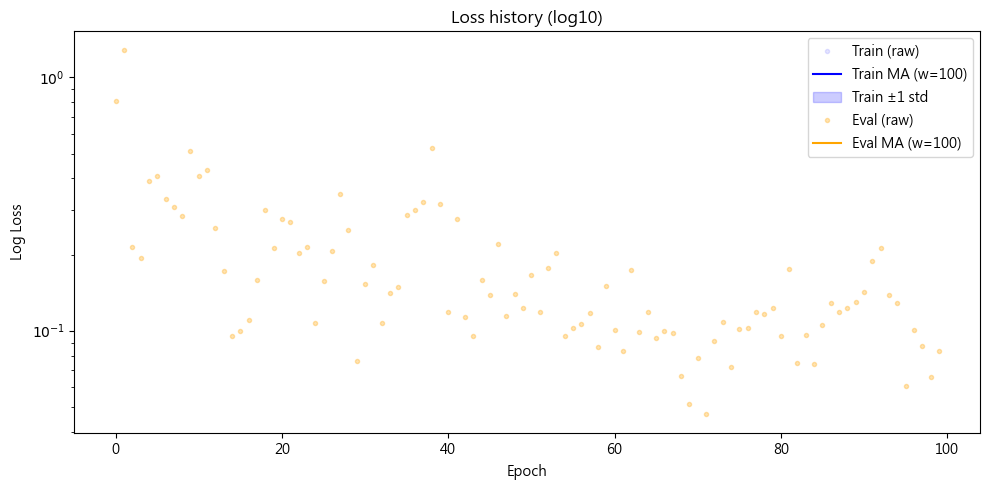

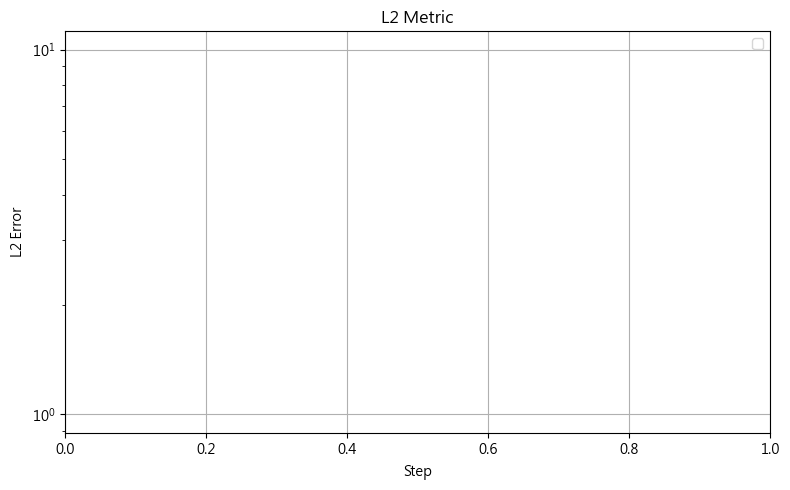

viz last batch in epoch


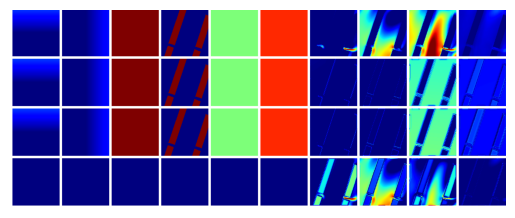

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9507414..1.2953787].


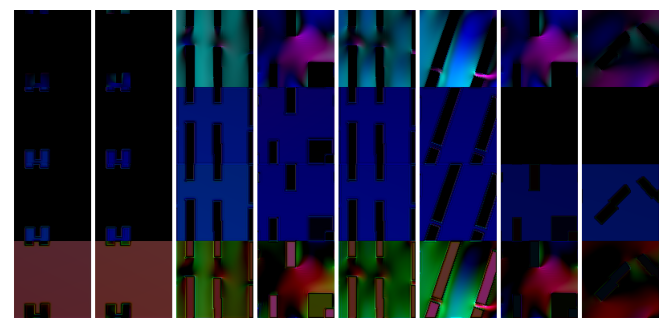

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94352126..1.4021823].


train x_pool


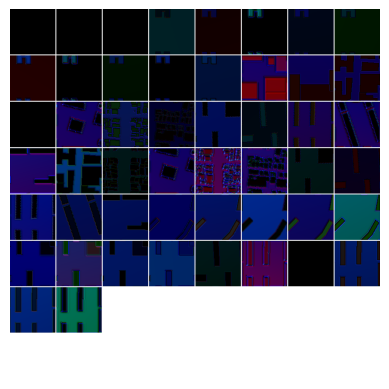

Training Epochs:   6%|▋         | 128/2000 [00:51<12:33,  2.49it/s]


KeyboardInterrupt: 

In [14]:
import json
import traceback
import os
import torch
import gc  # Python garbage collector

for run_id in range(50):
    remove_empty_dirs(r"C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA")

    try:
        cfg = resolve_list_options(CONFIG, OPTIONS_PATHS)


        # print(f"Run {run_id}:\n{cfg}")
        model = CAModel(cfg).to(DEVICE)
        # 指定輸入尺寸: (channels, height, width)
        in_channels = cfg["model"]["channels"]
        # summary(model, input_size=(in_channels, 64, 64))
        print("=== Perception Filters ===")
        print(f"filters: shape={tuple(model.filters.shape)}, requires_grad={model.filters.requires_grad}")

        print("\n=== Rule Block Layers ===")
        for name, layer in model.rule_block.named_children():
            if isinstance(layer, nn.Conv2d):
                print(f"{name}: Conv2d(in={layer.in_channels}, out={layer.out_channels}, kernel={layer.kernel_size})")
            else:
                print(f"{name}: {layer.__class__.__name__}")



        optimizer = Optimizer.Adam(model.parameters(), lr=cfg["optim"]["lr"])
        lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.7)

        model_path = get_output_path()

        run_training(
            cfg,
            model,
            optimizer,
            loss_fn=pinn_loss,
            metric_fn=metric_fn,
            lr_sched=lr_sched,
            output_path=model_path,
        )

        # 確保目錄存在再寫入
        os.makedirs(model_path, exist_ok=True)
        config_file_path = os.path.join(model_path, "config.json")
        with open(config_file_path, "w") as f:
            json.dump(cfg, f, indent=4)

    except Exception as e:
        log_file = f"{model_path}/training_error.log"
        with open(log_file, "a") as log_f:
            log_f.write(f"Run {run_id} failed:\n")
            log_f.write(traceback.format_exc())
            log_f.write("\n" + "-"*80 + "\n")
        print(f"Run {run_id} failed. See {log_file} for details.")

    finally:
        # -----------------------------
        # 釋放 GPU 記憶體
        # -----------------------------
        del model
        del optimizer
        del lr_sched
        torch.cuda.empty_cache()

        # -----------------------------
        # 釋放 Python 物件
        # -----------------------------
        gc.collect()



# After training

## viz pngs

In [ ]:
# import os
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# def show_all_png(root_dir):
#     png_files = []
#     for dirpath, _, filenames in os.walk(root_dir):
#         for f in filenames:
#             if f.lower().endswith(".png") :
#                 png_files.append(os.path.join(dirpath, f))

#     if not png_files:
#         print("No PNG files found.")
#         return

#     for img_path in png_files:
#         title = os.path.relpath(img_path, root_dir)
#         if title.startswith("E4-5.1"):
#             print(f"Showing {img_path}")
#             img = mpimg.imread(img_path)
#             plt.imshow(img)
#             plt.axis("off")
#             plt.title(title)  # 不顯示 root_dir 之前的路徑
#             plt.show()

# # 使用範例
# show_all_png(r"C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs")


# test model

In [ ]:
import torch
import numpy as np
import os
import imageio
from PIL import Image  # 用來 resize

output_dir = "temp_frames"
os.makedirs(output_dir, exist_ok=True)

# --- 初始化資料 ---
Y_batch = create_epoch_pool(mode="eval").to(DEVICE)  # [1, 32, 64, 64]
X_batch = init_X(Y_batch)  # [batch, channel, H, W]

# 假設模型已經載入並設定 eval
load_model = CAModel(channel_n=CHANNELS).to(DEVICE)
load_model.load_state_dict(torch.load(f"{model_path}/model.pth"))
load_model.eval()

rollout_steps = 50
frames = []
target_size = (1024, 1024)  # (W, H)

for t in range(rollout_steps):
    # 每步 rollout
    X_batch = load_model(X_batch, n_times=1)

    # 取第一個 batch 的前三個 channel作 RGB
    x_np = X_batch[0, 4:7].detach().cpu().numpy()  # shape: [3, H, W]
    frame = np.transpose(x_np, (1, 2, 0))         # shape: [H, W, 3]
    frame = np.clip(frame, 0, 1)                  # 確保值在 0~1
    frame_uint8 = (frame * 255).astype(np.uint8)

    # resize
    img = Image.fromarray(frame_uint8)
    img = img.resize(target_size, resample=Image.BILINEAR)
    frame_resized = np.array(img)

    # 選擇是否存單張 PNG
    frame_path = os.path.join(output_dir, f"{t:03d}.png")
    imageio.imwrite(frame_path, frame_resized)

    # 累積成影片幀
    frames.append(frame_resized)

# 儲存成 mp4
video_path = f"{model_path}/output.mp4"
imageio.mimsave(video_path, frames, fps=3)
print("Saved mp4:", video_path)


NameError: name 'create_epoch_pool' is not defined